# Shooting and flows

In [1]:
## Un fichier plus à jour dans "maison de Fermat" contient tous les flots
## Reprendre ce fichier et revoir tous les exemples

## Preliminaries

In [4]:
using ForwardDiff, DifferentialEquations, Plots, LinearAlgebra, MINPACK

In [5]:
# Alias for gradient and jacobian
grad(f, x) = ForwardDiff.gradient(f, x)
jac(f, x)  = ForwardDiff.jacobian(f, x);

## Regular case

The control problem consists in minimizing the cost functional

$$ \frac{1}{2} \int_{0}^{t_f} u^2(t) \,\mathrm{d}t \to \min, $$

considering that the evolution of the state $x=(x_1, x_2) \in \mathbb{R}^2$ is governed by the 
control system

$$ \dot{x}(t) = (x_2(t), u(t)), \quad |u(t)| \leq \mathbf{R}, $$

fixing the initial condition to

$$ x(0) = (-1, 0) $$

and considering that the system has to reach the final condition given by 

$$ x(t_f) = (0, 0).  $$

In [5]:
t0 = 0.
tf = 1.
x0 = [-1., 0.]
xf_target = [ 0., 0.]
p0_guess  = [11., 5.]
p⁰ = -1. # normal case
n  = 2;

In [18]:
struct Hamiltonian f::Function end
struct HamiltonianVectorField f::Function end
struct VectorField f::Function end
struct PseudoHamiltonian f::Function end
struct Mayer f::Function end
struct Lagrange 
    f::Function
    f⁰::Function 
end

### Hamiltonian

In [19]:
# Flow from a Hamiltonian
function Flow(H::Hamiltonian)

    h = H.f
    
    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        foo = z -> h(z[1:n], z[n+1:2*n])
        dh = grad(foo, z)
        dz[1:n] = dh[n+1:2n]
        dz[n+1:2n] = -dh[1:n]
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=[])
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = OrdinaryDiffEq.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, tf; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end;

In [7]:
# Maximizing control
control(x, p) = p[2]

# Hamiltonian
H(x, p) = p[1]*x[2]+p[2]*control(x, p)-0.5*control(x, p)^2

# Flow
z = Flow(Hamiltonian(H))

# Shoot
function shoot(p0)
    s = zeros(eltype(p0), 2)
    xf, pf = z(t0, x0, p0, tf)
    s[1:2] = xf - xf_target
    return s
end;

# Solve
S(ξ) = shoot(ξ)
S!(s, ξ) = ( s[:] = S(ξ); nothing )

ξ = p0_guess
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333274, -0.49999999999997724]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.386397
     2     1.306560e-07     1.999999e+00         0.798322
     3     2.256238e-14     3.058743e-13         0.000315
     4     1.094680e-14     1.411272e-27         0.000355
     5     7.562980e-13     6.813320e-24         0.000266
     6     1.723043e-14     6.615618e-24         0.000318
     7     1.723043e-14     0.000000e+00         0.000552
     8     5.886609e-15     4.670057e-28         0.000220
     9     1.744917e-14     1.840412e-27         0.000197
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [11.0, 5.0]
 * Zero: [12.000000000000076, 6.000000000000047]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at m

2-element Vector{Float64}:
 12.000000000000076
  6.000000000000047

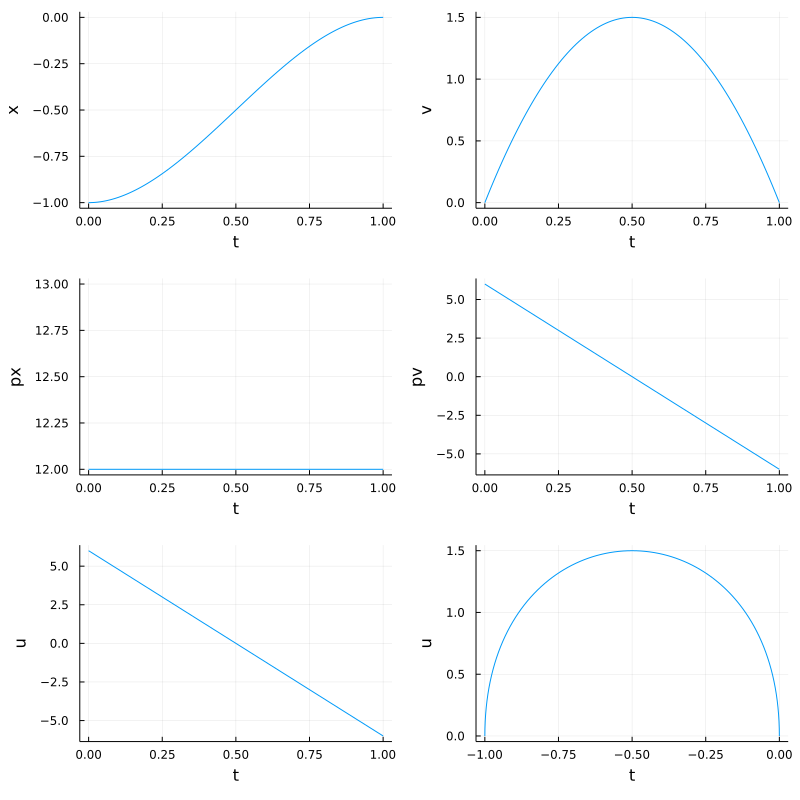

In [8]:
# Plots
ode_sol = z((t0, tf), x0, p0, saveat=0.01);

t = ode_sol.t
x = [ ode_sol[1:n,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[n+1:2n, j] for j in 1:size(t, 1) ]
u = control.(x, p)

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))

### Hamiltonian system

In [9]:
# Fonction permettant de calculer le flot d'un système hamiltonien
function Flow(HV::HamiltonianVectorField)

    hv = HV.f
    
    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        dz[:] = hv(z[1:n], z[n+1:2*n])
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=0.05)
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = DifferentialEquations.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, t; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, t), x0, p0; abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end;

In [10]:
# Control
control(x, p) = p[2]

# Hamiltonian vector field
Hv(x, p) = [x[2], control(x, p), 0., -p[1]]

# Flow
z = Flow(HamiltonianVectorField(Hv))

# Shoot
function shoot(p0)
    s = zeros(eltype(p0), 2)
    xf, pf = z(t0, x0, p0, tf)
    s[1:2] = xf - xf_target
    return s
end;

# Solve
S(ξ) = shoot(ξ)
S!(s, ξ) = ( s[:] = S(ξ); nothing )

ξ = p0_guess
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333274, -0.49999999999997724]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.007367
     2     1.306560e-07     1.999999e+00         0.000457
     3     2.256238e-14     3.058743e-13         0.000165
     4     1.094680e-14     1.411272e-27         0.000180
     5     7.562980e-13     6.813320e-24         0.000137
     6     1.723043e-14     6.615618e-24         0.000216
     7     1.723043e-14     0.000000e+00         0.000399
     8     5.886609e-15     4.670057e-28         0.000136
     9     1.744917e-14     1.840412e-27         0.000128
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [11.0, 5.0]
 * Zero: [12.000000000000076, 6.000000000000047]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at m

2-element Vector{Float64}:
 12.000000000000076
  6.000000000000047

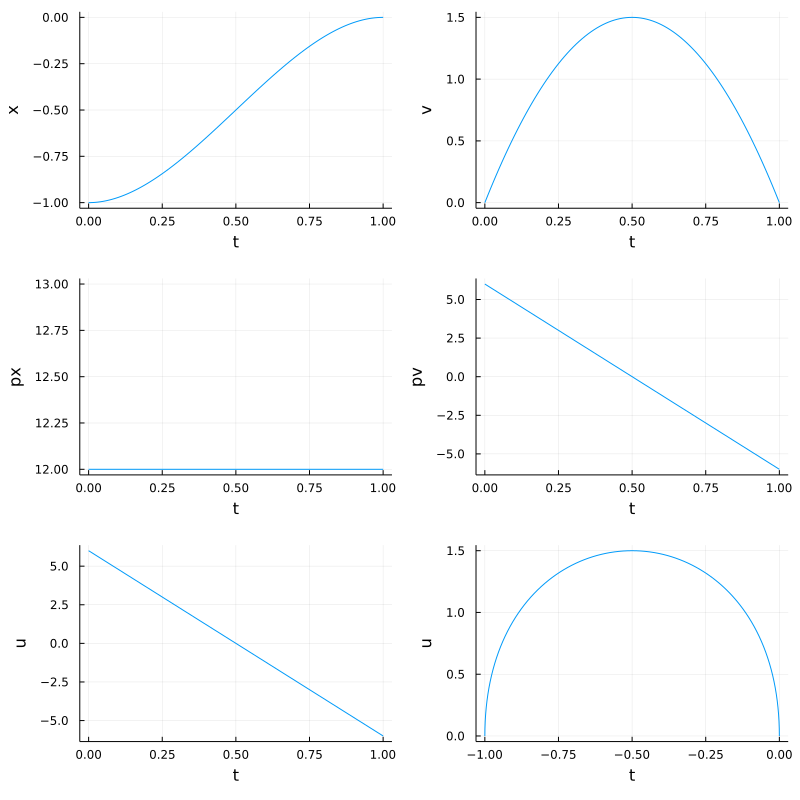

In [11]:
# Plots
ode_sol = z((t0, tf), x0, p0, saveat=0.01);

n  = 2 
t = ode_sol.t
x = [ ode_sol[1:n,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[n+1:2n, j] for j in 1:size(t, 1) ]
u = control.(x, p)

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))

### Vector field

In [12]:
# Flow of a vector field
function Flow(VF::VectorField)

    vf = VF.f
    
    function rhs!(dx, x, dummy, t)
        dx[:] = vf(x)
    end
    
    function f(tspan, x0; abstol=1e-12, reltol=1e-12, saveat=0.05)
        ode = ODEProblem(rhs!, x0, tspan)
        sol = DifferentialEquations.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, t; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, t), x0; abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end]
    end
    
    return f

end;

In [13]:
# Control
control(x, p) = p[2]

# Vector field
F(z) = [z[2], control(z[1:2], z[3:4]), 0., -z[3]]

# Flow
z = Flow(VectorField(F))

# Shoot
function shoot(p0)
    s = zeros(eltype(p0), 2)
    zf = z(t0, [x0; p0], tf)
    s[1:2] = zf[1:2] - xf_target
    return s
end;

# Solve
S(ξ) = shoot(ξ)
S!(s, ξ) = ( s[:] = S(ξ); nothing )

ξ = p0_guess
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333274, -0.49999999999997724]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.007244
     2     1.306560e-07     1.999999e+00         0.000467
     3     2.256238e-14     3.058743e-13         0.000162
     4     1.094680e-14     1.411272e-27         0.000180
     5     7.562980e-13     6.813320e-24         0.000134
     6     1.723043e-14     6.615618e-24         0.000127
     7     1.723043e-14     0.000000e+00         0.000297
     8     5.886609e-15     4.670057e-28         0.000161
     9     1.744917e-14     1.840412e-27         0.000124
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [11.0, 5.0]
 * Zero: [12.000000000000076, 6.000000000000047]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at m

2-element Vector{Float64}:
 12.000000000000076
  6.000000000000047

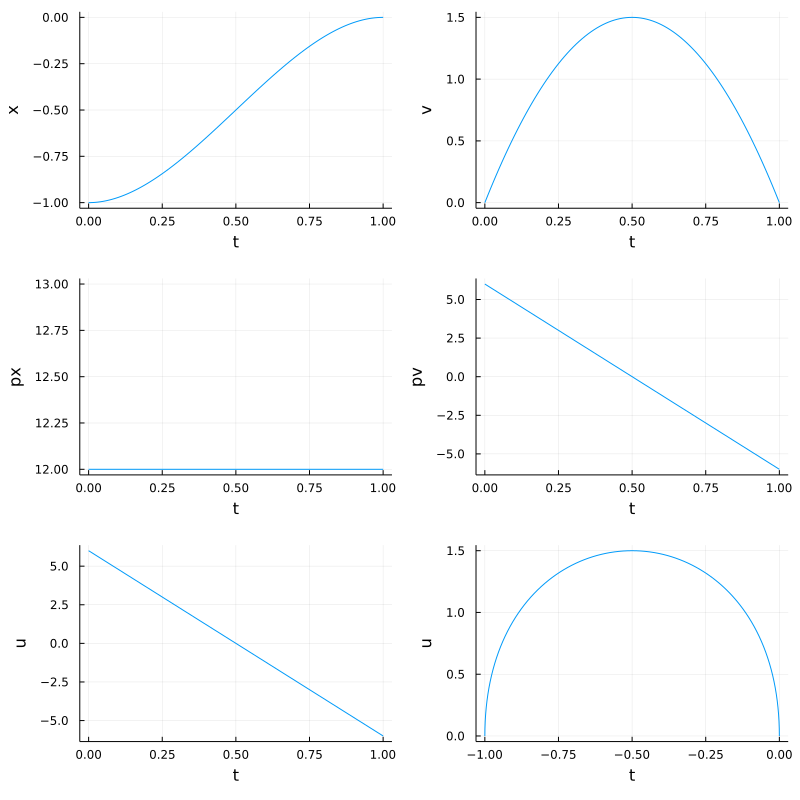

In [14]:
# Plots
ode_sol = z((t0, tf), [x0; p0], saveat=0.01);

n  = 2 
t = ode_sol.t
x = [ ode_sol[1:n,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[n+1:2n, j] for j in 1:size(t, 1) ]
u = control.(x, p)

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))

### Pseudo-Hamiltonian

In [15]:
# Flow from a pseudo-Hamiltonian
function Flow(H::PseudoHamiltonian; p⁰::Number=Inf)

    if p⁰==Inf
        h = H.f
    else
        h(x, p, u) = H.f(x, p, p⁰, u)
    end
    
    function ∂h∂z(z, u)
        n = size(z, 1)÷2
        foo(z) = h(z[1:n], z[n+1:2*n], u)
        return grad(foo, z)
    end
    
    function ∂h∂u(z, u)
        n = size(z, 1)÷2
        foo(u) = h(z[1:n], z[n+1:2*n], u)
        return grad(foo, u)
    end
    
    ∂h∂u(x, p, u) = ∂h∂u([x; p], u)
    
    ∂²h∂u²(z, u)  = jac(u->∂h∂u(z, u), u)
    ∂²h∂z∂u(z, u) = jac(u->∂h∂z(z, u), u)
    
    function rhs!(dw, w, λ, t)
        # w = (z, u) = (x, p, u)
        n, m = λ
        z  = w[1:2n]
        u  = w[2n+1:2n+m]
        dh = ∂h∂z(z, u)
        hv = [dh[n+1:2n]; -dh[1:n]]
        dw[1:2n] = hv  
        dw[2n+1:2n+m] = -∂²h∂u²(z, u)\(∂²h∂z∂u(z, u)'*hv)
    end
    
    function f(tspan, x0, p0, u0; abstol=1e-12, reltol=1e-12, saveat=[])
        w0 = [ x0 ; p0; u0 ]
        λ = [size(x0, 1), size(u0, 1)]
        ode = ODEProblem(rhs!, w0, tspan, λ)
        sol = OrdinaryDiffEq.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, u0, tf; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, tf), x0, p0, u0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2n, end], sol[2n+1:end, end]
    end
    
    return f, ∂h∂u

end;

In [16]:
# Pseudo-Hamiltonian
H(x, p, u) = p[1]*x[2]+p[2]*u[1]-0.5*u[1]^2

# Flow
z, ∂h∂u = Flow(PseudoHamiltonian(H))

# Shoot
function shoot(p0, u0)
    s = zeros(eltype(p0), 3)
    xf, pf, uf = z(t0, x0, p0, u0, tf)
    s[1:2] = xf - xf_target
    s[3:3] = ∂h∂u(x0, p0, u0)
    return s
end;

# Solve
S(ξ) = shoot(ξ[1:2], ξ[3:3])
S!(s, ξ) = ( s[:] = S(ξ); nothing )

u0_guess = [p0_guess[2]]
ξ = [p0_guess; u0_guess]
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
    u0 = nl_sol.x[n+1];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333275, -0.49999999999997896, 0.0]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.007900
     2     4.687091e-08     3.000000e+00         0.004104
     3     1.580974e-14     1.127605e-14         0.000998
     4     4.072912e-15     3.455211e-28         0.000976
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [11.0, 5.0, 5.0]
 * Zero: [12.00000000000003, 5.999999999999996, 5.999999999999996]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 0.014065 seconds
 * Function Calls: 4
 * Jacobian Calls (df/dx): 1


5.999999999999996

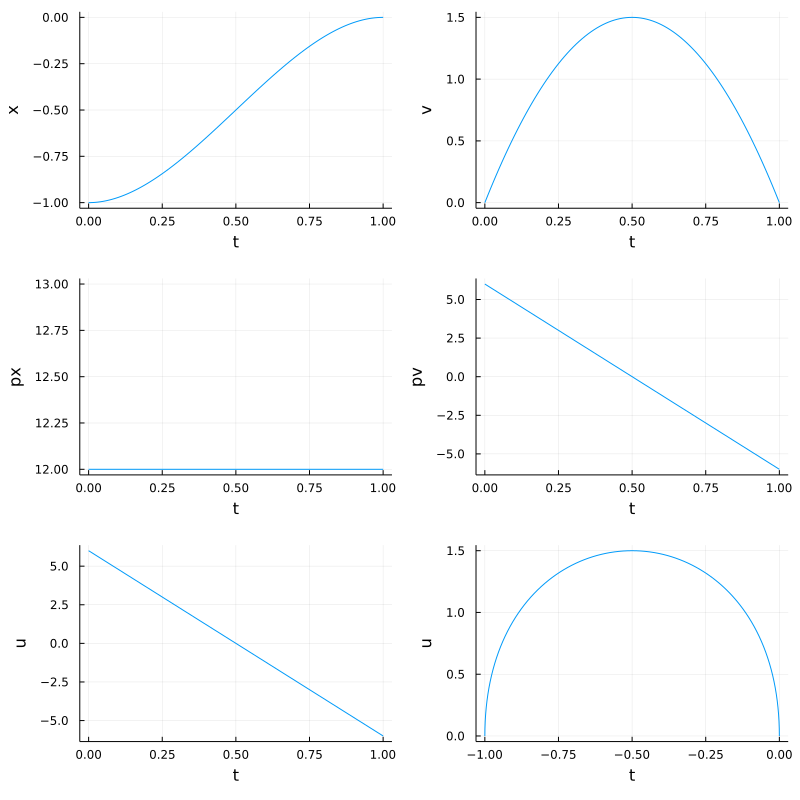

In [17]:
# Plots
ode_sol = z((t0, tf), x0, p0, u0, saveat=0.01);

n = 2 
m = 1
t = ode_sol.t
x = [ ode_sol[1:n,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[n+1:2n, j] for j in 1:size(t, 1) ]
u = [ ode_sol[2n+1:2n+m, j] for j in 1:size(t, 1) ]

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, [ u[i][1] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))


### Mayer

In [18]:
# Flow from Mayer system
Flow(Σu::Mayer) = Flow(PseudoHamiltonian((x, p, u) -> p'*Σu.f(x,u)));

In [19]:
# Augmented state: Mayer case
x0_ = [x0;  0.0]

# Control system
f(x, u) = [x[2], u[1], 0.5*u[1]^2]

# Flow
z, ∂h∂u = Flow(Mayer(f))

# Shoot
function shoot(p0, u0)
    s = zeros(eltype(p0), 3)
    p0_ = [p0; p⁰]
    xf_, pf_, uf = z(t0, x0_, p0_, u0, tf)
    s[1:2] = xf_[1:2] - xf_target
    s[3:3] = ∂h∂u(x0_, p0_, u0)
    return s
end;

# Solve
S(ξ) = shoot(ξ[1:2], ξ[3:3])
S!(s, ξ) = ( s[:] = S(ξ); nothing )
jS(ξ) = jac(S, ξ)
jS!(js, ξ) = ( js[:] = jS(ξ); nothing )

u0_guess  = [p0_guess[2]]
ξ = [p0_guess; u0_guess]
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, jS!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
    u0 = nl_sol.x[n+1];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333292, -0.49999999999997924, 0.0]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.016833
     2     1.232673e-14     3.000000e+00        13.207186
     3     4.142321e-15     2.566953e-27         0.003695
     4     8.229017e-15     8.046381e-29         0.003262
     5     5.576298e-15     1.798603e-28         0.003194
     6     8.229017e-15     1.798603e-28         0.006055
     7     5.576298e-15     1.798603e-28         0.002078
     8     4.039235e-14     2.172523e-27         0.002124
     9     1.596943e-14     1.935865e-27         0.002154
    10     8.421449e-15     3.786532e-29         0.001978
    11     1.491824e-15     2.839899e-29         0.001904
    12     1.163510e-14     4.733165e-30         0.002065
    13     3.216025e-15     3.155444e-30         0.002040
    14     8.906757e-15     2.319251e-28         0.006761

6.000000000000004

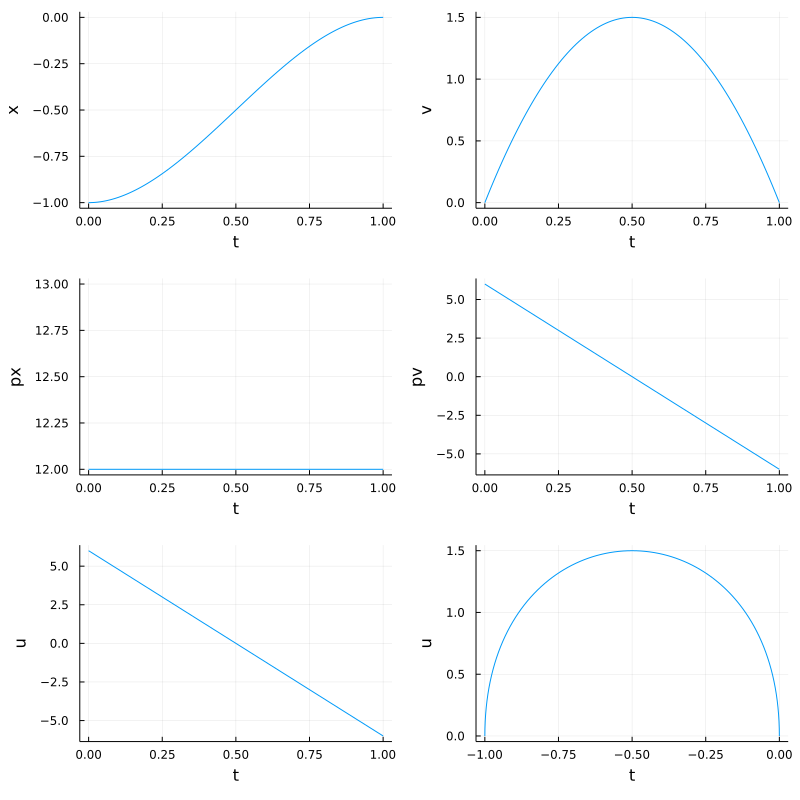

In [20]:
p0_ = [p0; p⁰]
ode_sol = z((t0, tf), x0_, p0_, u0, saveat=0.01);

nn = 3 
m = 1
t = ode_sol.t
x = [ ode_sol[1:nn,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[nn+1:2nn, j] for j in 1:size(t, 1) ]
u = [ ode_sol[2nn+1:2nn+m, j] for j in 1:size(t, 1) ]

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, [ u[i][1] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))


### Lagrange

In [26]:
# Flow from Lagrange system
Flow(Σu::Lagrange, p⁰::Number=-1.0) = Flow(PseudoHamiltonian((x, p, p⁰, u) -> p⁰*Σu.f⁰(x,u)+p'*Σu.f(x,u)), p⁰=p⁰);

In [28]:
# Lagrange
f(x, u) = [x[2], u[1]]
f⁰(x, u) = 0.5*u[1]^2

# Flow
z, ∂h∂u = Flow(Lagrange(f, f⁰)) #, -1.0)

# Shoot
function shoot(p0, u0)
    s = zeros(eltype(p0), 3)
    xf, pf, uf = z(t0, x0, p0, u0, tf)
    s[1:2] = xf - xf_target
    s[3:3] = ∂h∂u(x0, p0, u0)
    return s
end;

# Solve
S(ξ) = shoot(ξ[1:2], ξ[3:3])
S!(s, ξ) = ( s[:] = S(ξ); nothing )
jS(ξ) = jac(S, ξ)
jS!(js, ξ) = ( js[:] = jS(ξ); nothing )

u0_guess  = [p0_guess[2]]
ξ = [p0_guess; u0_guess]
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, jS!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
    u0 = nl_sol.x[n+1];
else
    error("Not converged")
end

Initial value of shooting:
[-0.3333333333333275, -0.49999999999997896, 0.0]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.010192
     2     6.927955e-15     3.000000e+00         0.158779
     3     3.773088e-15     2.193033e-28         0.001927
     4     1.949494e-14     1.530390e-28         0.001460
     5     1.601160e-14     8.219931e-28         0.001342
     6     1.605164e-14     2.325562e-27         0.002808
     7     2.469801e-14     3.881196e-28         0.001332
     8     3.910348e-14     6.793670e-27         0.001202
     9     1.010557e-13     4.895040e-26         0.001321
    10     1.101018e-14     7.304221e-26         0.001219
    11     1.633035e-14     3.297439e-28         0.001206
    12     1.426157e-13     1.205821e-25         0.001208
    13     8.969484e-16     1.455590e-25         0.001201
Results of Nonlinear Solver Algorithm
 * Algorithm: Modif

6.000000000000006

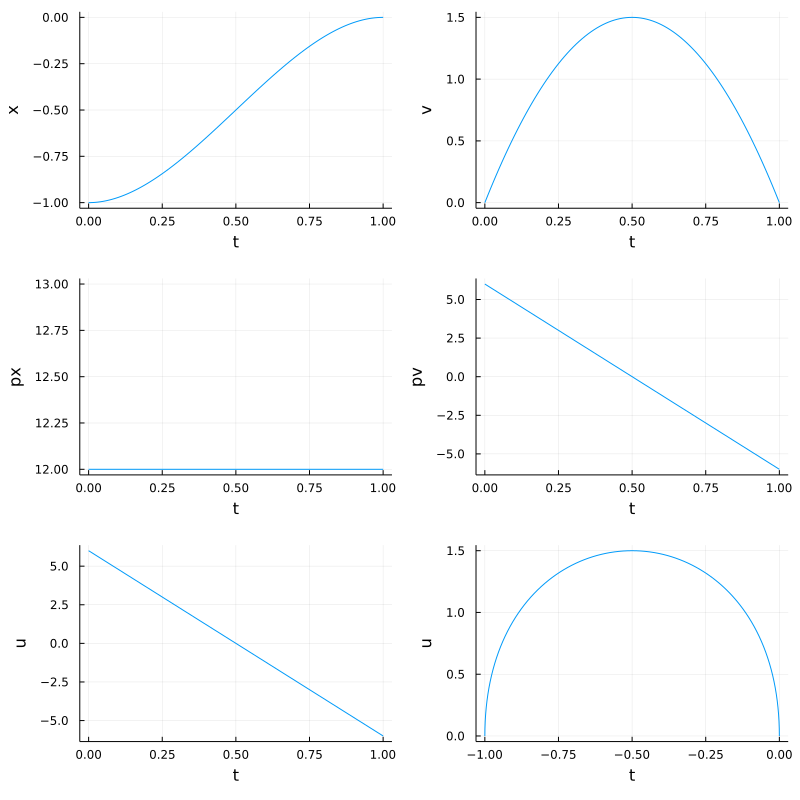

In [29]:
ode_sol = z((t0, tf), x0, p0, u0, saveat=0.01);

m = 1
t = ode_sol.t
x = [ ode_sol[1:n,    j] for j in 1:size(t, 1) ]
p = [ ode_sol[n+1:2n, j] for j in 1:size(t, 1) ]
u = [ ode_sol[2n+1:2n+m, j] for j in 1:size(t, 1) ]

N = size(t, 1)
x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
u_plot  = plot(t, [ u[i][1] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
xv_plot  = plot([ x[i][1] for i=1:N ], [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, v_plot, px_plot, pv_plot, u_plot, xv_plot, layout = (3,2), size = (800, 800)))


## Bang-Singular case

The control problem consists in minimizing the cost functional

$$ \frac{1}{2} \int_{0}^{t_f} \left( x^2(t)+y^2(t) \right) \,\mathrm{d}t \to \min, $$

considering that the evolution of the state $(x,y) \in \mathbb{R}^2$ is governed by the 
control system

$$ \dot{x}(t) = u(t), \quad \dot{y}(t) = - u(t) - \frac{y(t)}{2}, \quad |u(t)| \leq M, $$

fixing the initial condition to

$$ (x(0), y(0)) = (1, -1/2) $$

and considering that the system has to reach the final condition given by 

$$ (x(t_f), y(t_f)) = (1/2, 1/2).  $$

### Crochets de Lie et de Poisson

In [6]:
function Lie(X, f)
    
    function Xf(x)
        df = grad(f, x)
        return df'*X(x)
    end
    
    return Xf

end
    
#function Lie(X, Y)
#
#    function XY(x)
#        dX = jac(X, x)
#        dY = jac(Y, x)
#        return dY*X(x)-dX*Y(x)
#    end
#
#    return XY
#
#end

function Poisson(f, g)

    function fg(x, p)
        n = size(x, 1)
        ff = z -> f(z[1:n], z[n+1:2n])
        gg = z -> g(z[1:n], z[n+1:2n])
        df = grad(ff, [ x ; p ])
        dg = grad(gg, [ x ; p ])
        return df[n+1:2n]'*dg[1:n] - df[1:n]'*dg[n+1:2n]
    end

    return fg

end;

### Singular control

The singular control is given by

$$ u(x, p) = -\frac{H_{001}(x,p)}{H_{101}(x,p)}.$$


In [7]:
# Brackets and singular control
F0(x) = [0.0, -x[2]/2.0, (x[1]^2+x[2]^2)/2.0] # Mayer form
F1(x) = [1.0, -1.0, 0.0]
H0(x, p) = p'*F0(x)
H1(x, p) = p'*F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us(x, p) = -H001(x, p)/H101(x, p)

# Test of the singular control computation
us_true(x, p) = -(1.0/8.0)*(p[2]/p[3])

x = zeros(3)
p = [1.0, 2.0, -1.0]
println("Error = ", abs(us(x, p) - us_true(x, p)))

Error = 0.0


In [10]:
struct PseudoHamiltonianScalarAffine 
    h₀::Function 
    h₁::Function 
end
struct MayerScalarAffine 
    f₀::Function 
    f₁::Function 
end
struct LagrangeScalarAffine 
    f₀::Function
    f₁::Function
    f₀⁰::Function 
    f₁⁰::Function 
end
@enum CONTROL min=1 max=2 singular=3

In [62]:
# Flow from a pseudo-Hamiltonian
function Flow(H::PseudoHamiltonianScalarAffine, control_bounds::Tuple{Number, Number}, control::CONTROL; p⁰::Number=Inf)

    if p⁰==Inf
        h₀ = H.h₀
        h₁ = H.h₁
    else
        h₀(x, p) = H.h₀(x, p, p⁰)
        h₁(x, p) = H.h₁(x, p, p⁰)
    end
    
    function dh₀(z)
        n = size(z, 1)÷2
        foo(z) = h₀(z[1:n], z[n+1:2n])
        return grad(foo, z)
    end

     function dh₁(z)
        n = size(z, 1)÷2
        foo(z) = h₁(z[1:n], z[n+1:2n])
        return grad(foo, z)
    end
    
    H₀₁  = Poisson(h₀, h₁)
    H₀₀₁ = Poisson(h₀, H₀₁)
    H₁₀₁ = Poisson(h₁, H₀₁)
    us(x, p) = -H₀₀₁(x, p)/H₁₀₁(x, p)
    
    function rhs!(dz, z, n, t)
        x  = z[1:n]
        p  = z[n+1:2n]
        if control==singular
            u = us(x, p)
        elseif control==min
            u = control_bounds[1]
        elseif control==max
            u = control_bounds[2]
        else
            nothing
        end
        dh0 = dh₀(z)
        dh1 = dh₁(z)
        hv0 = [dh0[n+1:2n]; -dh0[1:n]]
        hv1 = [dh1[n+1:2n]; -dh1[1:n]]
        dz[1:2n] = hv0 + u*hv1
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=[])
        z0 = [ x0 ; p0 ]
        n = size(x0, 1)
        ode = ODEProblem(rhs!, z0, tspan, n)
        sol = OrdinaryDiffEq.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, tf; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2n, end]
    end
    
    return f, us

end;

In [63]:
function Flow(Σu::MayerScalarAffine, control_bounds::Tuple{Number, Number}, control::CONTROL) 
    h₀(x, p) = p'*Σu.f₀(x)
    h₁(x, p) = p'*Σu.f₁(x)
    return Flow(PseudoHamiltonianScalarAffine(h₀, h₁), control_bounds, control);
end;

In [64]:
function Flow(Σu::LagrangeScalarAffine, control_bounds::Tuple{Number, Number}, control::CONTROL, p⁰::Number=-1.0) 
    h₀ = (x, p) -> p⁰*Σu.f₀⁰(x) + p'*Σu.f₀(x)
    h₁ = (x, p) -> p⁰*Σu.f₁⁰(x) + p'*Σu.f₁(x)
    return Flow(PseudoHamiltonianScalarAffine(h₀, h₁), control_bounds, control, p⁰=p⁰);
end;

In [59]:
# Parameters
t0 = 0.0
tf = 10.0
x0 = [1.0, 0.0]
xf_target = [1.0/2.0, 0.0]
n  = 2;

In [52]:
# Hamiltonians (regular, singular)
H(x, p, u) = H0(x, p) + u*H1(x, p)
Hm(x, p) = H(x, p, -1.0)
Hs(x, p) = H(x, p, us(x, p))

# Flows
fm = Flow(Hamiltonian(Hm))
fs = Flow(Hamiltonian(Hs));

# Shooting function
function shoot(p0, t1, t2) # B- S B- structure

    x1, p1 = fm(t0, [x0; 0.0], [p0; -1.0], t1)
    x2, p2 = fs(t1, x1, p1, t2)
    xf, pf = fm(t2, x2, p2, tf)
    s = zeros(eltype(p0), 4)
    s[1] = xf[1] - xf_target[1]
    s[2] = xf[2] - xf_target[2]
    s[3] = H1(x1, p1)
    s[4] = H01(x1, p1)

    return s

end;

# Solve
S(ξ) = shoot(ξ[1:2], ξ[3], ξ[4])
S!(s, ξ) = ( s[:] = S(ξ); nothing )

p0_guess = [-1.0, -1.0]./tf
t1_guess = 0.1*tf
t2_guess = 0.95*tf

ξ = [p0_guess; t1_guess; t2_guess]
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
    t1 = nl_sol.x[1+n];
    t2 = nl_sol.x[2+n];
else
    error("Not converged")
end

Initial value of shooting:
[5.657821127426554, -1.9850057410403732, 0.05436826624448282, -0.9597545474524887]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.657821e+00     0.000000e+00         0.368875
     2     2.783467e-01     1.629801e+00         2.398704
     3     8.507264e-02     1.736593e-02         0.275921
     4     3.080635e-02     1.903822e-03         0.273471
     5     1.413083e-02     1.232862e-04         0.276487
     6     1.040939e-03     7.821305e-05         0.283575
     7     5.906608e-05     5.342882e-07         0.269438
     8     4.491786e-06     9.878885e-10         0.325153
     9     3.658149e-07     6.636032e-12         0.449290
    10     6.699865e-08     6.497363e-14         0.249065
    11     4.125189e-09     1.494362e-15         0.282631
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [-0.1, -0.1, 1.0, 9.5]
 * Zero: [-1.0895547493400208

9.729740517673665

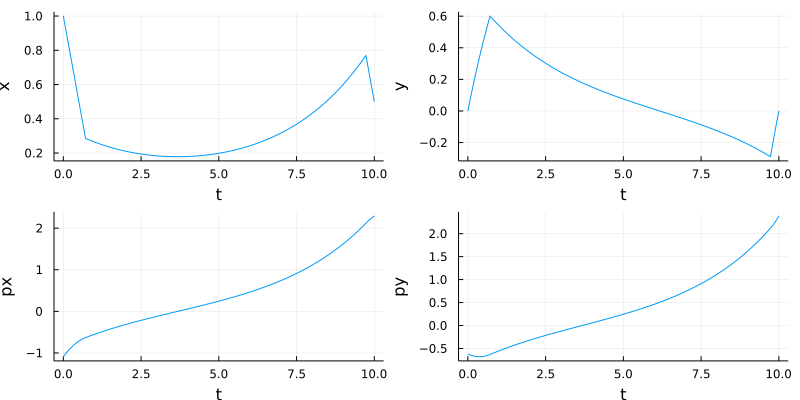

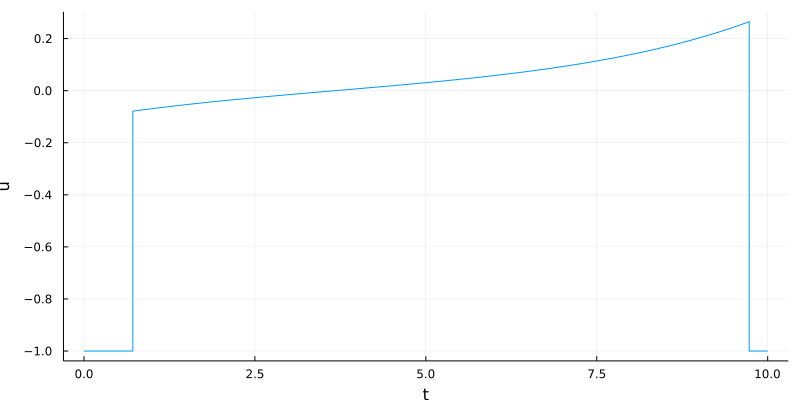

In [53]:
# Plots
ode_sol = fm((t0, t1), [x0; 0.0], [p0; -1.0])
tt0 = ode_sol.t
xx0 = [ ode_sol[1:3, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[4:6, j] for j in 1:size(tt0, 1) ]
uu0 = -ones(size(tt0, 1))

ode_sol = fs((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1:3, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:6, j] for j in 1:size(tt1, 1) ]
uu1 = us.(xx1, pp1)

ode_sol = fm((t2, tf), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1:3, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[4:6, j] for j in 1:size(tt2, 1) ]
uu2 = -ones(size(tt2, 1))

t = [ tt0 ; tt1 ; tt2 ]
x = [ xx0 ; xx1 ; xx2 ]
p = [ pp0 ; pp1 ; pp2 ]
u = [ uu0 ; uu1 ; uu2 ]
N = length(t)

x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
y_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "y", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
py_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "py", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, y_plot, px_plot, py_plot, layout = (2,2), size = (800, 400)))
display(plot(u_plot, layout = (1,1), size = (800, 400)))

In [65]:
# Flow(Σu::MayerScalarAffine, control_bounds::Tuple{Number, Number}, control::CONTROL)
fm, _   = Flow(MayerScalarAffine(F0, F1), (-1.0, 1.0), min);
fs, uus = Flow(MayerScalarAffine(F0, F1), (-1.0, 1.0), singular);

# Shooting function
function shoot(p0, t1, t2) # B- S B- structure

    x1, p1 = fm(t0, [x0; 0.0], [p0; -1.0], t1)
    x2, p2 = fs(t1, x1, p1, t2)
    xf, pf = fm(t2, x2, p2, tf)
    s = zeros(eltype(p0), 4)
    s[1] = xf[1] - xf_target[1]
    s[2] = xf[2] - xf_target[2]
    s[3] = H1(x1, p1)
    s[4] = H01(x1, p1)

    return s

end;

# Solve
S(ξ) = shoot(ξ[1:2], ξ[3], ξ[4])
S!(s, ξ) = ( s[:] = S(ξ); nothing )

p0_guess = [-1.0, -1.0]./tf
t1_guess = 0.1*tf
t2_guess = 0.95*tf

ξ = [p0_guess; t1_guess; t2_guess]
println("Initial value of shooting:\n", S(ξ), "\n\n")

nl_sol = fsolve(S!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:n];
    t1 = nl_sol.x[1+n];
    t2 = nl_sol.x[2+n];
else
    error("Not converged")
end

Initial value of shooting:
[8.983489741515244, -3.042092088577611, 0.05436826624448282, -0.9597545474524887]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     8.983490e+00     0.000000e+00         0.127904
     2     1.665098e-01     1.745016e+00         0.579677
     3     1.691770e-01     2.212545e-02         0.092910
     4     1.147167e-01     5.436448e-03         0.079794
     5     6.840439e-02     8.410858e-04         0.090682
     6     8.965796e-03     2.409171e-03         0.079080
     7     8.889920e-04     4.505054e-05         0.092039
     8     1.391792e-04     3.607403e-07         0.080508
     9     1.832866e-05     6.989568e-09         0.091240
    10     2.092534e-06     1.800116e-10         0.064095
    11     1.757813e-07     2.038882e-12         0.092299
    12     2.434847e-09     1.205067e-14         0.131737
    13     7.511436e-12     2.343764e-18         0.141422
Results of Nonlinear Sol

9.729740515144787

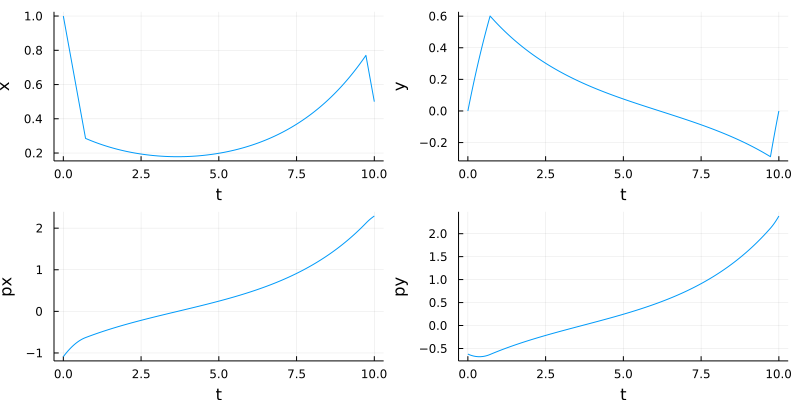

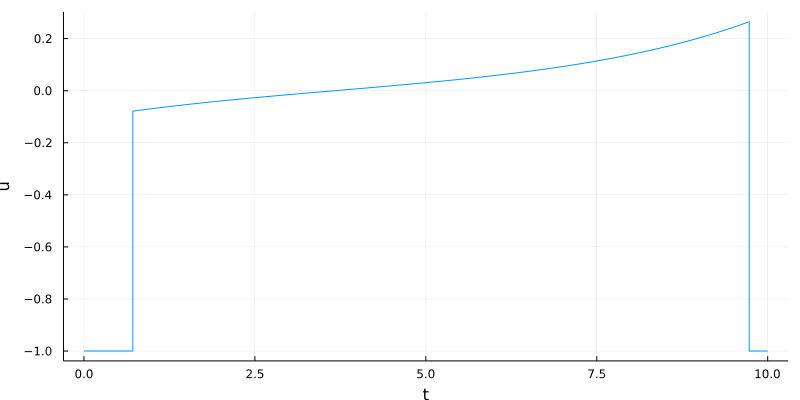

In [66]:
# Plots
ode_sol = fm((t0, t1), [x0; 0.0], [p0; -1.0])
tt0 = ode_sol.t
xx0 = [ ode_sol[1:3, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[4:6, j] for j in 1:size(tt0, 1) ]
uu0 = -ones(size(tt0, 1))

ode_sol = fs((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1:3, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:6, j] for j in 1:size(tt1, 1) ]
uu1 = uus.(xx1, pp1)

ode_sol = fm((t2, tf), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1:3, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[4:6, j] for j in 1:size(tt2, 1) ]
uu2 = -ones(size(tt2, 1))

t = [ tt0 ; tt1 ; tt2 ]
x = [ xx0 ; xx1 ; xx2 ]
p = [ pp0 ; pp1 ; pp2 ]
u = [ uu0 ; uu1 ; uu2 ]
N = length(t)

x_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "x", legend = false)
y_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "y", legend = false)
px_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "px", legend = false)
py_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "py", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot, y_plot, px_plot, py_plot, layout = (2,2), size = (800, 400)))
display(plot(u_plot, layout = (1,1), size = (800, 400)))